## Tasks:
1. **Environment Setup**
2. **Load IMDb (50,000 records)**
3. **Data preparation**

## Environment Setup

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [139]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import re
import string
import time
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (TextVectorization)
from keras.preprocessing.text import one_hot, Tokenizer
from keras_preprocessing.sequence import pad_sequences

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/loc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
print(1)

1


In [41]:
# Change directory to the project folder
# data_path = '/content/drive/My Drive/Colab Notebooks/imdb_sentiment_analysis_model'
data_path = '/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/dataset/imdb_dataset_50k.csv'

## Load IMDb Movie Reviews dataset (50,000 reviews)


In [42]:
movie_reviews = pd.read_csv(data_path)

# Convert the sentiment column to binary
movie_reviews['sentiment'] = movie_reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [43]:
# Display the first 5 rows of the dataset
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
# Check the shape of the dataset
movie_reviews.shape

(50000, 2)

In [6]:
# Check for missing values
movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

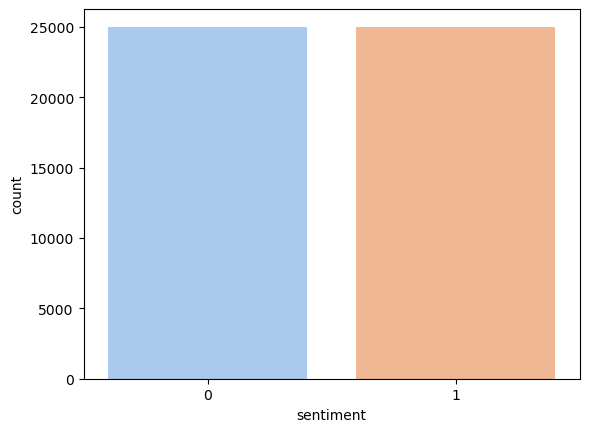

In [7]:
# Plot the count of each sentiment
sns.countplot(x='sentiment', data=movie_reviews, hue='sentiment', palette='pastel', legend=False)

# Data Preparation

In [288]:
import unicodedata

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Convert the stopwords to a TensorFlow constant
stopwords_tensor = tf.constant(list(stop_words))

def remove_stopwords(sentence):
    words = tf.strings.split(sentence)
    filtered_words = tf.boolean_mask(words, tf.math.logical_not(tf.reduce_any(tf.equal(words[:, None], stopwords_tensor[None, :]), axis=1)))
    sentence = tf.strings.reduce_join(filtered_words, separator=' ')
    return sentence

def standardization(sen):
    
    lowercase = tf.strings.lower(sen)

    # Remove punctuations and numbers
    sentence = tf.strings.regex_replace(lowercase, '[^a-z]', ' ')
    
    # Take off of html tag
    sentence = tf.strings.regex_replace(sentence, '<[^>]+>', ' ')
    
    # Single character removal
    sentence = tf.strings.regex_replace(sentence, r'\b\w\b', ' ')
    
    # Remove multiple spaces
    sentence = tf.strings.regex_replace(sentence, ' +', ' ')
    
    # Remove stopwords
    sentence = remove_stopwords(sentence)
    
    # Normalize UTF-8 and remove accented characters using standard Python libraries
    # def normalize_and_remove_accents(text):
    #     text = unicodedata.normalize('NFKD', text.numpy().decode('utf-8'))
    #     return ''.join(c for c in text if unicodedata.category(c) != 'Mn')

    # sentence = tf.py_function(normalize_and_remove_accents, [sentence], tf.string)

    return sentence


In [289]:
# movie_reviews['review'][2]
# Example usage
sentence = tf.constant("lộc This is a sample sentence, showing off the stop words filtration.")
standardization(sentence)

<tf.Tensor: shape=(), dtype=string, numpy=b'sample sentence showing stop words filtration'>

In [262]:
standardization(movie_reviews['review'][2])

<tf.Tensor: shape=(), dtype=string, numpy=b' thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point risk addiction thought it was proof that woody allen is still fully in control of the style many of us have grown to love br br this was the most laughed at one of woody comedies in years dare say decade while ve never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into average but spirited young woman br br this may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman great comedy to go see with friends '>

In [263]:
#train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True,download=True,data_dir=imdb_data_dir)
X_train, X_test, y_train, y_test = train_test_split(movie_reviews['review'], movie_reviews['sentiment'], test_size=0.2, random_state=42) # Quay lai cach chia cu de compare

## Preparing embedding layer

In [264]:
# word_tokenizer = Tokenizer()
# word_tokenizer.fit_on_texts(X_train) # create a dictionary

# X_train = word_tokenizer.texts_to_sequences(X_train) # match the words in the dictionary to the words in the sentences
# X_test = word_tokenizer.texts_to_sequences(X_test)

In [265]:
# len(word_tokenizer.word_index)

112280

In [62]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

# vocab_length = len(word_tokenizer.word_index) + 1

# vocab_length

112281

In [72]:
# len(X_train)
# for i in range(10):
#     print(len(X_train[i]))

410
282
93
178
313
120
68
283
230
776


In [76]:
# Padding all reviews to fixed length 100

# maxlen = 100

# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [235]:
# len(X_train)
# for i in range(10):
#     print(X_train)

39087    That's what I kept asking myself during the ma...
30893    I did not watch the entire movie. I could not ...
45278    A touching love story reminiscent of In the M...
16398    This latter-day Fulci schlocker is a totally a...
13653    First of all, I firmly believe that Norwegian ...
                               ...                        
11284    `Shadow Magic' recaptures the joy and amazemen...
44732    I found this movie to be quite enjoyable and f...
38158    Avoid this one! It is a terrible movie. So wha...
860      This production was quite a surprise for me. I...
15795    This is a decent movie. Although little bit sh...
Name: review, Length: 40000, dtype: object
39087    That's what I kept asking myself during the ma...
30893    I did not watch the entire movie. I could not ...
45278    A touching love story reminiscent of In the M...
16398    This latter-day Fulci schlocker is a totally a...
13653    First of all, I firmly believe that Norwegian ...
             

In [290]:
BATCH_SIZE=64
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [291]:
vectorize_layer = TextVectorization( # nay vua stand, tokenriza cac kieu
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [292]:
X_train, X_test, y_train, y_test = train_test_split(movie_reviews['review'], movie_reviews['sentiment'], test_size=0.2, random_state=42) # Quay lai cach chia cu de compare

# Convert X_train and X_test to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_data = train_data.map(lambda text, label: text)
# Build the dictionary from X_train (need to convert to tensor)
vectorize_layer.adapt(train_data)


2024-07-10 13:45:14.067000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [40000]
	 [[{{node Placeholder/_1}}]]


TypeError: in user code:

    File "/Users/loc/Documents/anaconda3/envs/tf1/lib/python3.9/site-packages/keras/engine/base_preprocessing_layer.py", line 123, in adapt_step  *
        self.update_state(data)
    File "/Users/loc/Documents/anaconda3/envs/tf1/lib/python3.9/site-packages/keras/layers/preprocessing/text_vectorization.py", line 475, in update_state  **
        self._lookup_layer.update_state(self._preprocess(data))
    File "/Users/loc/Documents/anaconda3/envs/tf1/lib/python3.9/site-packages/keras/layers/preprocessing/text_vectorization.py", line 571, in _preprocess
        if inputs.shape.rank > 1:

    TypeError: '>' not supported between instances of 'NoneType' and 'int'


In [284]:
vectorize_layer.get_vocabulary()[22]

'are'

In [277]:
def vectorizer(review, label):
    return vectorize_layer(review),label

In [279]:
train_dataset = vectorize_layer(X_train)
val_dataset = vectorize_layer(X_test)

In [280]:
train_dataset.shape
val_dataset.shape

# Batch and prefetch the dataset
train_data = train_data.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)